In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturb mode
warnings.filterwarnings('ignore')

%matplotlib inline

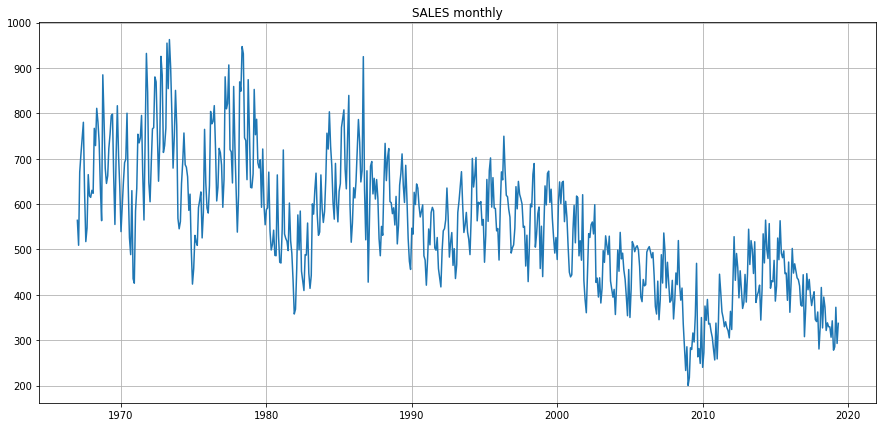

In [2]:
data = pd.read_csv('D:/Udemy/time-series/DAUTONSA.csv', index_col=['DATE'], parse_dates=['DATE'])
data.index.freq='MS'
plt.figure(figsize=(15, 7))
plt.plot(data['SALES'])
plt.title('SALES monthly')
plt.grid(True)
plt.show()


We can see this a very long time series and it goes back 50 years. From observation we can see that every 10 year
pattern is different and probably affected by the state of the economy and political outcomes in that decade.
It is unwise to fit any model to this ever changing data points with different trends and seasonality. Therefore
we would work with the last 10 year data points to get a more realistic forecasts.

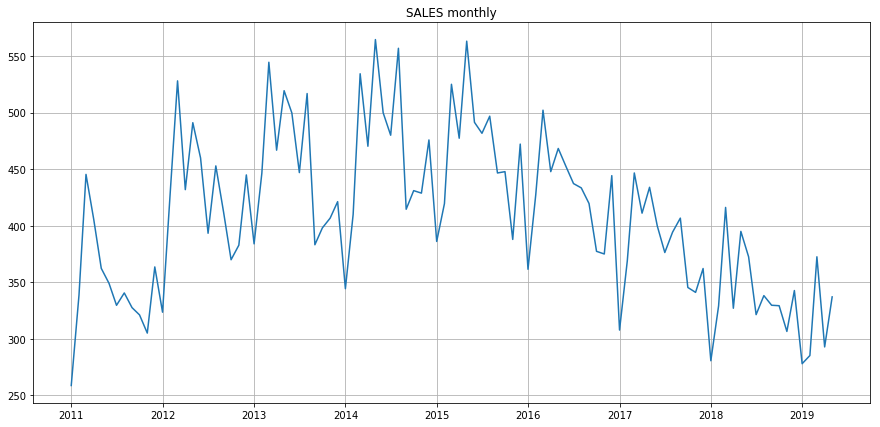

In [3]:
data = data['2011-01-01':]

plt.figure(figsize=(15, 7))
plt.plot(data['SALES'])
plt.title('SALES monthly')
plt.grid(True)
plt.show()

We will now calculate the moving average over multiple data points to get the trend. We will experiment with 3,4 and 12
data point average

In [4]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def plotMovingAverage(series, window, plot_intervals=False, scale=1.3, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

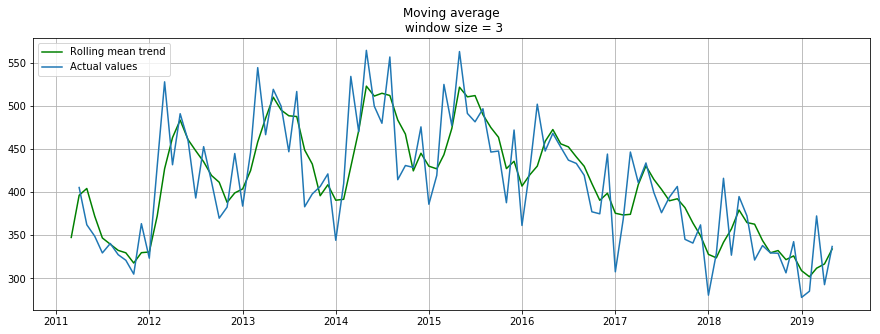

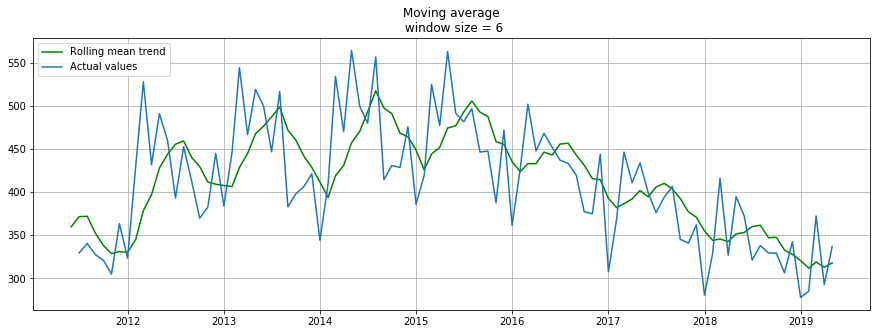

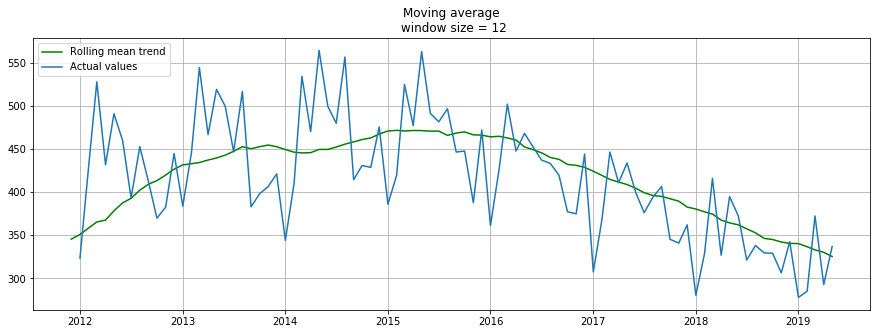

In [102]:
#plotting for 3, 4, 6 and 12 months
plotMovingAverage(data, 3)
plotMovingAverage(data, 6)
plotMovingAverage(data, 12)


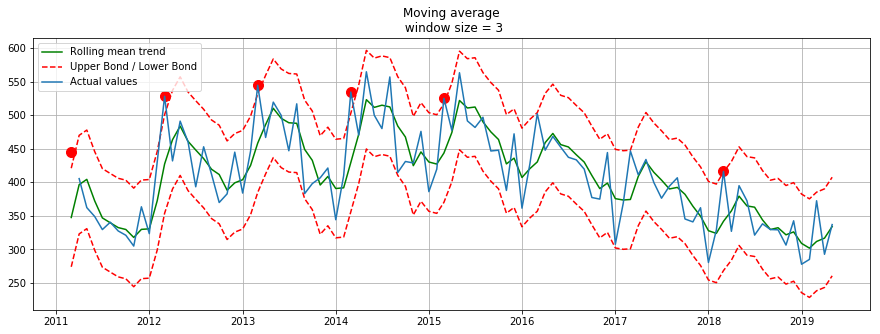

In [5]:
#Lets try plotting the upper and lower bound along with the moving average and anomaly points.
plotMovingAverage(data, 3, plot_intervals=True, plot_anomalies=True)

As we can see our simple model is not able to understand the seasonal peak in the data and classifying many points as
an anomaly. Now we will check the different components of the series namely, trend, seasonal pattern which repeats itself over
a fixed period.

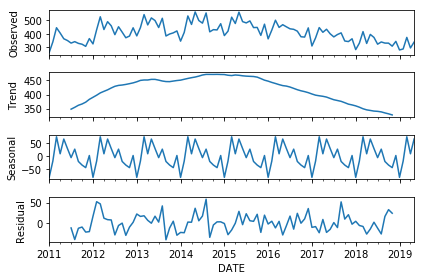

In [6]:
decomposition = sm.tsa.seasonal_decompose(data['SALES'], model='additive')
fig = decomposition.plot()
plt.show()

We will now try to see if the data is stationary by performing Dicky-Fuller test.

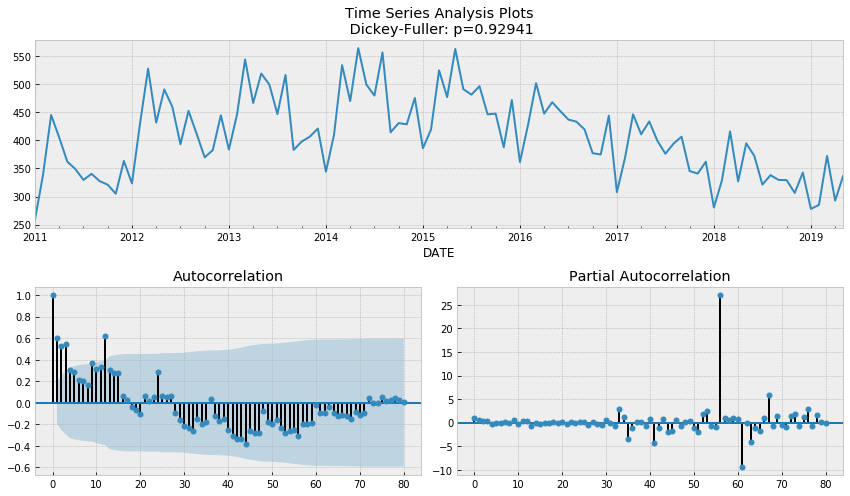

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data['SALES'], lags=80)

We can visibly see that our series is non-stationary and it will be difficult for any model to forecast non-stationary data points.
We need differencing here to make the series stationary. We will try shifting values by 1.

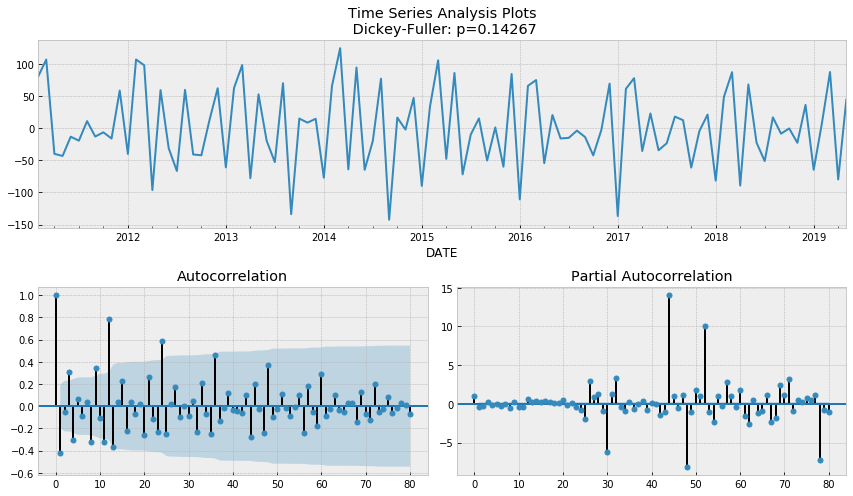

In [8]:
data_diff = data['SALES'] - data['SALES'].shift(1)

tsplot(data_diff[1:], lags=80)

The above plot looks somewhat stationary, yet still we cannot reject the null hypothesis that the series is not stationary
as the p value in the Dicky-Fuller test is not small enough. Let us go for one more differencing of the differenced series.

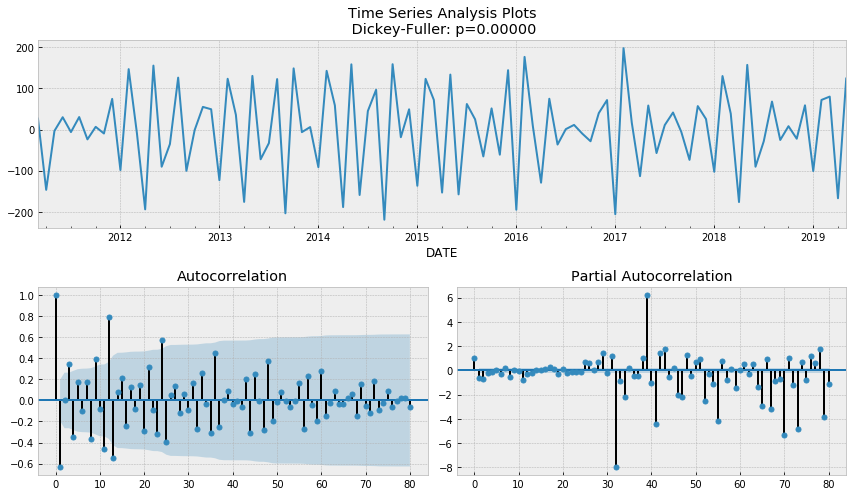

In [9]:
data_diff = data_diff - data_diff.shift(1)
tsplot(data_diff[1+1:], lags=80)

We can now reject(p value <0.05) the null hypothesis and state that the series has indeed become stationary. We will now try to run ARIMA model over our statinary time series. We will do a grid search for the candidate parameters.
And try to find our the best model with lowest AIC.

In [199]:
#We can also use a grid search to get the optimum parameters, however it may be time-consuming.
ps = range(0, 14)
d=2
qs = range(0, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 3)
s = 12 # season length is still 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

420

In [200]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(data['SALES'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    
result_table = optimizeSARIMA(parameters_list, d, D, s)
print(result_table)


        parameters         aic
0    (13, 0, 0, 1)  834.307437
1    (13, 0, 1, 1)  835.914581
2    (13, 0, 1, 0)  841.348444
3     (2, 4, 0, 1)  841.479380
4    (13, 0, 0, 0)  842.874428
5     (1, 4, 0, 0)  842.989505
6     (0, 3, 1, 1)  843.299489
7     (8, 3, 1, 1)  843.743741
8     (0, 3, 0, 0)  843.968701
9     (1, 4, 1, 1)  844.180891
10    (3, 4, 0, 1)  844.187211
11    (2, 1, 1, 1)  844.692534
12    (1, 4, 0, 1)  844.834093
13    (1, 4, 1, 0)  844.862638
14    (2, 4, 0, 0)  844.881055
15    (4, 2, 0, 0)  844.977354
16    (3, 4, 1, 1)  845.232919
17    (0, 3, 0, 1)  845.387058
18    (2, 4, 1, 1)  845.485494
19    (0, 3, 1, 0)  845.529242
20    (8, 3, 0, 1)  845.609091
21    (2, 1, 0, 0)  845.758587
22    (4, 2, 1, 1)  845.843041
23    (3, 1, 1, 1)  845.864226
24    (9, 3, 1, 1)  846.060067
25    (3, 1, 0, 0)  846.139094
26    (4, 1, 0, 0)  846.251803
27    (8, 3, 0, 0)  846.375165
28    (2, 4, 1, 0)  846.497861
29    (8, 3, 1, 0)  846.654716
..             ...         ...
78    (

In [11]:
# Set one year for testing
train = data.iloc[:-12]
test = data.iloc[-12:]
print(test)

              SALES
DATE               
2018-06-01  372.417
2018-07-01  321.267
2018-08-01  338.095
2018-09-01  329.564
2018-10-01  329.158
2018-11-01  306.410
2018-12-01  342.587
2019-01-01  277.863
2019-02-01  285.093
2019-03-01  372.433
2019-04-01  292.705
2019-05-01  336.959


In [14]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(train['SALES'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                               SALES   No. Observations:                   89
Model:             SARIMAX(13, 2, 0)x(0, 1, 1, 12)   Log Likelihood                -348.123
Date:                             Tue, 02 Jul 2019   AIC                            726.246
Time:                                     15:21:18   BIC                            761.008
Sample:                                 01-01-2011   HQIC                           740.126
                                      - 05-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4816      0.150     -9.887      0.000      -1.775      -1.188
ar.L2         -1.7771      

In [15]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(13, 2, 0)(0, 1, 1, 12) Predictions')

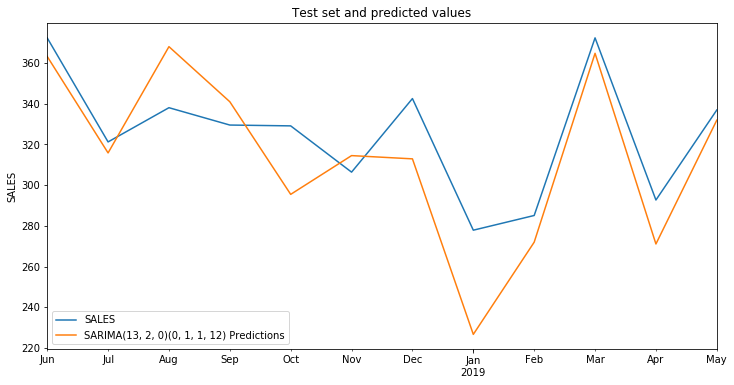

In [16]:
# Plot predictions against known values
title = 'Test set and predicted values'
ylabel='SALES'
xlabel=''

ax = test['SALES'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [18]:
#Let us now evaluate the error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


error = mean_squared_error(test['SALES'], predictions)**0.5
print(f'SARIMA(13,2,0)(0,1,1,12) Root Mean Squared Error: {error:11.10}')

error = mean_absolute_percentage_error(test['SALES'], predictions)
print(f'SARIMA(13,2,0)(0,1,1,12) Mean Absolute Percentage Error: {error:11.10}')

SARIMA(13,2,0)(0,1,1,12) Root Mean Squared Error: 23.39959641
SARIMA(13,2,0)(0,1,1,12) Mean Absolute Percentage Error: 5.997682784


We have a comparitively low error rate on the test set. This seems a good fit as determined by our parameter grid search.
We will now fit the same model on the entire dataset to predict the future timesteps.

In [19]:
#Let us now fit the data to the entire series and check the residual graph
best_model=sm.tsa.statespace.SARIMAX(data['SALES'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                               SALES   No. Observations:                  101
Model:             SARIMAX(13, 2, 0)x(0, 1, 1, 12)   Log Likelihood                -402.154
Date:                             Tue, 02 Jul 2019   AIC                            834.307
Time:                                     15:28:21   BIC                            871.296
Sample:                                 01-01-2011   HQIC                           849.202
                                      - 05-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4606      0.127    -11.499      0.000      -1.710      -1.212
ar.L2         -1.7822      

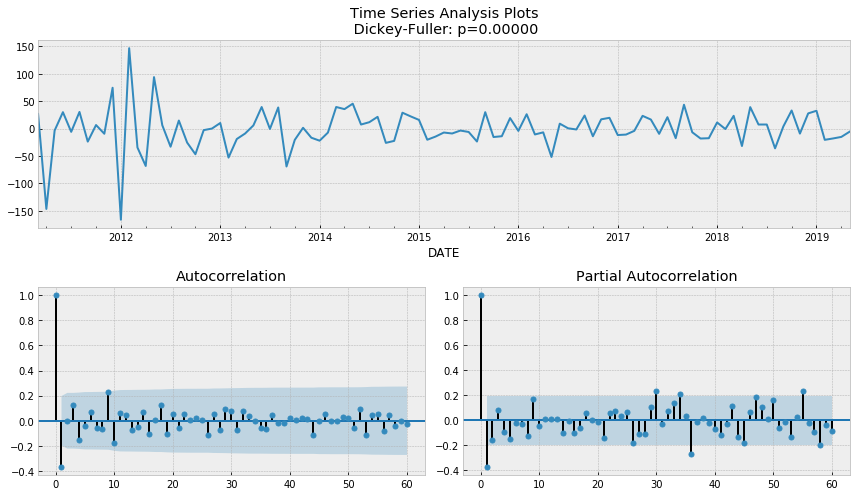

In [20]:
#Plotting the residual
tsplot(best_model.resid[1+1:], lags=60)

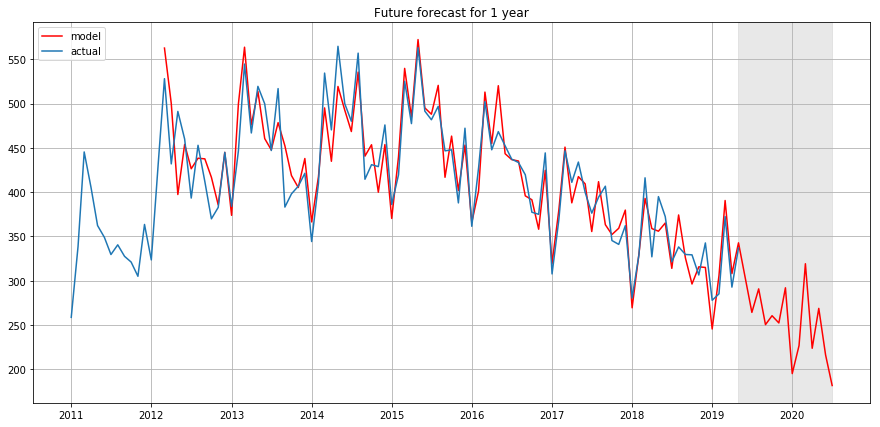

In [23]:
#Let us now predict the unseen future for 12 timesteps i.e for 1 year.
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data1 = series.copy()
    data1.columns = ['actual']
    data1['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data1['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data1.shape[0], end = data1.shape[0]+n_steps)
    forecast = data1.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning

#     print(len(forecast), len(series))
#     error = mean_absolute_percentage_error(forecast, series)

    plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Future forecast for 1 year")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(series.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(series, label="actual")
    plt.legend()
    plt.grid(True);
    

 
#Function call
plotSARIMA(data['SALES'], best_model, 12)

 We get a Mean Absolute Percentage error of 5.99% which is actually very good. We can correctly predict the series almost 
 95% of the time. We can see that our forecast captures the seasonality and also the trend of the series.
 
 # We should ensure that we do not predict more timesteps into the future than the length of our test set. We have proof of our model's performance only for the length of our test set number of time steps which is 12 in our case.

# Now will try feature engineering to model time series data as a classic regression problem.

In [56]:
data.head(5)

,SALES,MONTH,YEAR
DATE,,,
2011-01-01,258.576,1,2011
2011-02-01,338.615,2,2011
2011-03-01,445.315,3,2011
2011-04-01,405.418,4,2011
2011-05-01,362.214,5,2011


In [38]:
data["MONTH"] = data.index.month
data["YEAR"] = data.index.year

In [ ]:
#########################

In [50]:
#Function for train and test split
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [42]:
#We can encode the features using target mean values which will give some predictive powers to the month and year feature.
#Just encoding month to be 1, 2 or 3 does not give any predictive power to the machine learning algorithms.
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [48]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
        test_size: float
            size of the test dataset after train/test split as percentage of dataset
        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # adding lags of series as a feature
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features like month and year
    data["MONTH"] = data.index.month
    data["YEAR"] = data.index.year
#     data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['month_average'] = list(map(
            code_mean(data[:test_index], 'MONTH', "y").get, data.MONTH))
        data["year_average"] = list(map(
            code_mean(data[:test_index], 'YEAR', "y").get, data.YEAR))

        # drop encoded variables 
        data.drop(["MONTH", "YEAR"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test =\
    timeseries_train_test_split(X, y, test_size)

    return X_train, X_test, y_train, y_test
  
  

In [53]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.2):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
#         cv = cross_val_score(model, X_train, y_train, 
#                                     cv=tscv, 
#                                     scoring="neg_mean_squared_error")
#         #mae = cv.mean() * (-1)
        deviation = prediction.std()
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [58]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    plt.title("Feature importance from highest to lowest")
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Let us try a simple linear regression and analyze the result

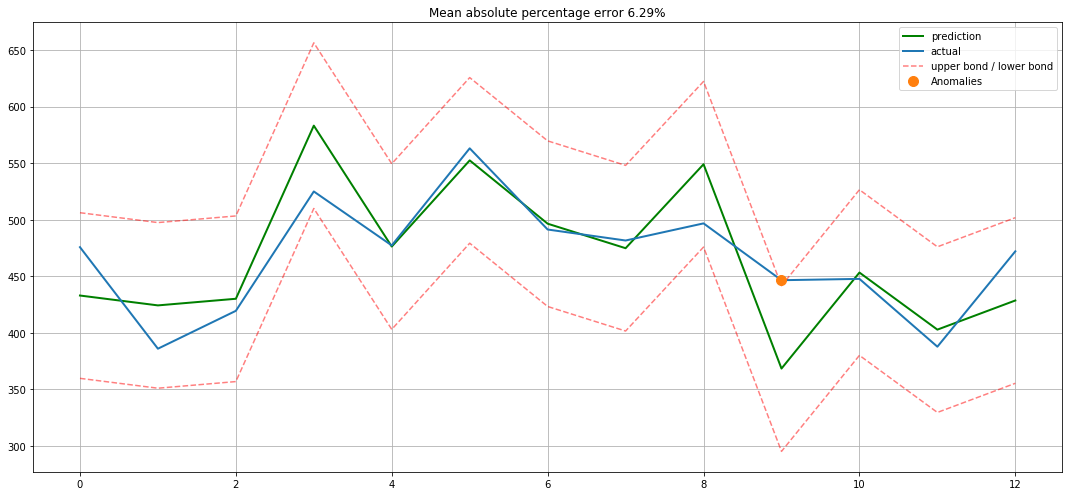

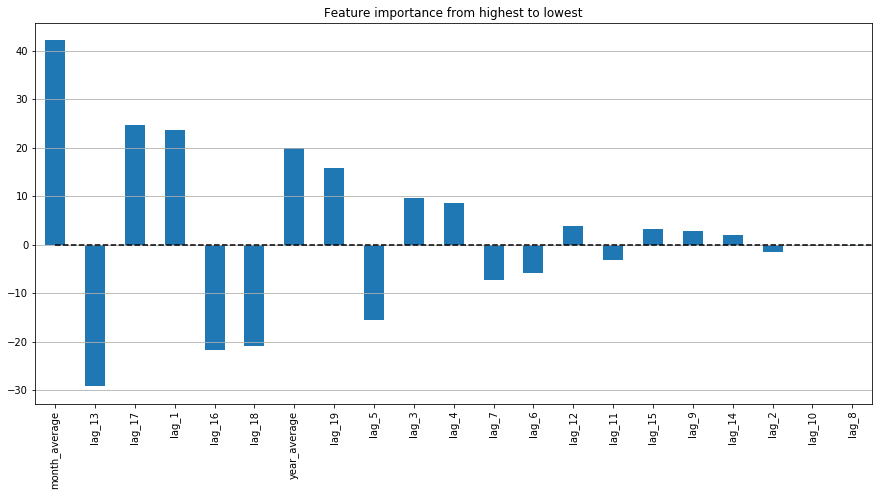

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

#Normalizing the dataset to have all values in standard range.
scaler = StandardScaler()

X_train, X_test, y_train, y_test =\
prepareData(data['SALES'], lag_start=1, lag_end=20, test_size=0.3, target_encoding=True)

#Fit standardization on train set and then extend it to the test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Instantiating and fitting the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

From the first plot above we can see that the test set has a mean absolute percentage error of 6.29%
The second plot shows that month_average is given too much importance and is probably overfitting, ignoring other features.
To test the overfitting of the model we will compare the error with training set

In [146]:
prediction_train = lr.predict(X_train_scaled)
mean_absolute_percentage_error(prediction_train, y_train)

1.744880511881593

We have a mean absolute percentage error of 1.7 on the training set and 6.29 on the test set. This clears our doubt that the model is overfitting and needs to be regularized to be able to predict unforseen samples. We will try regularization technique like lasso and ridge to see if we can get a lower magnitude coefficients and can generalize well.

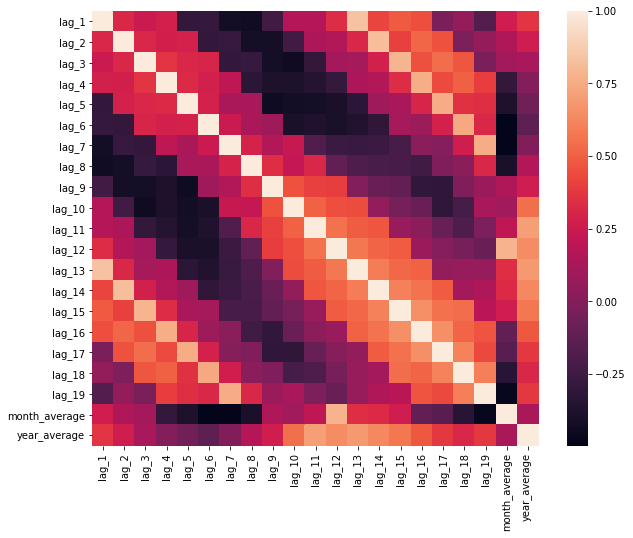

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

# Ridge regularization 

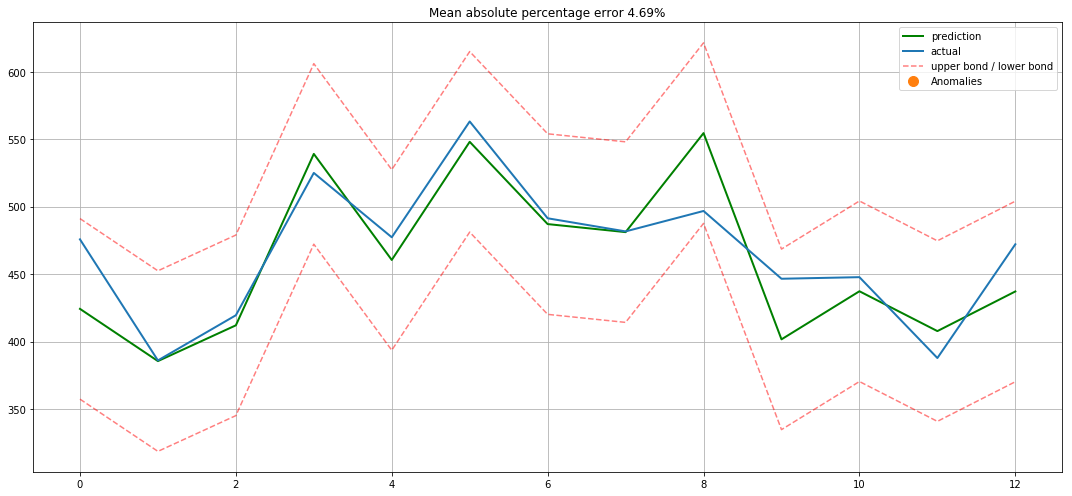

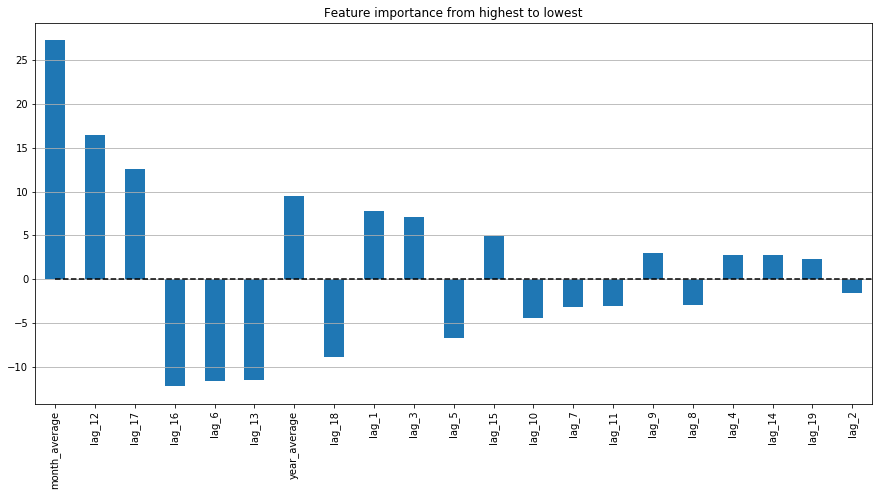

In [76]:
from sklearn.linear_model import Lasso, Ridge

ridge = Ridge(alpha=1.1)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can see that the month_average has reduced from more than 40 to just above 25 due to regularization which tends to penalize
larger coefficient values. We get a lower error percentage than the basic linear regression model. Next we will try the Lasso regularization to see if some of the features are forced to be zero. 

# Lasso regularization

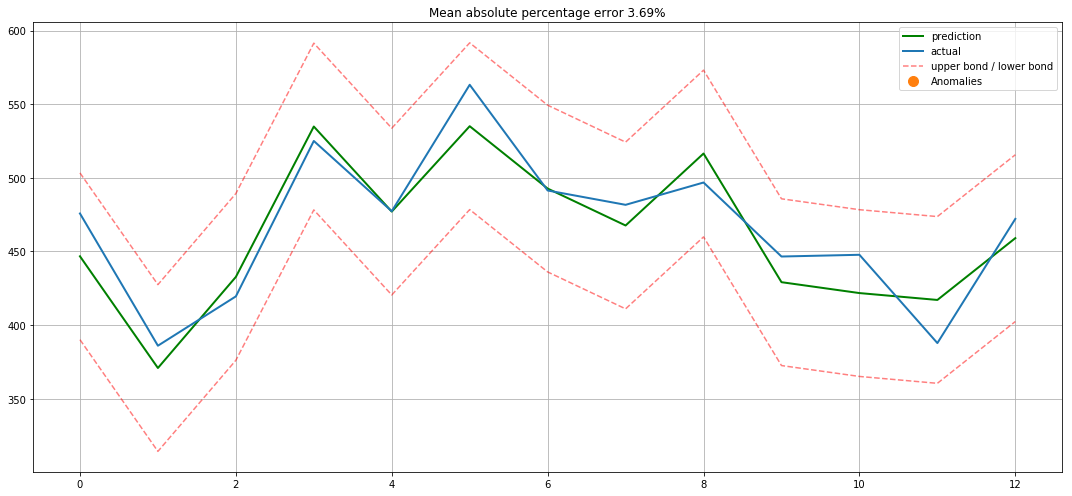

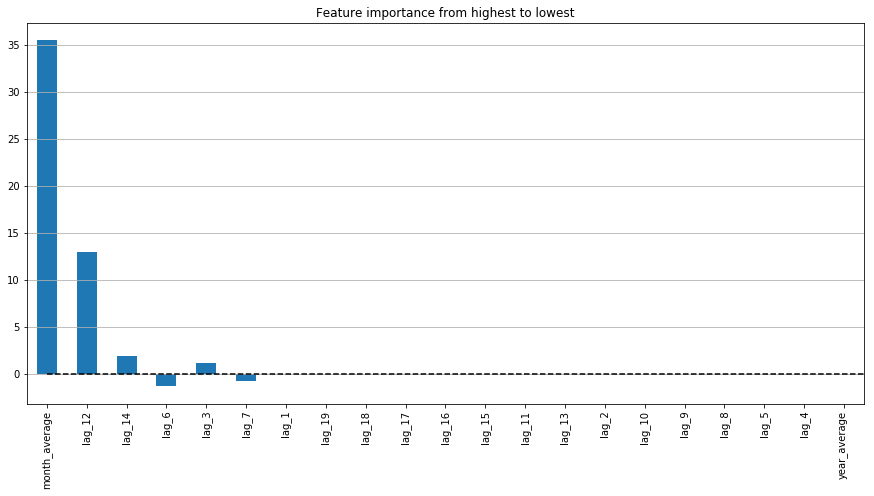

In [143]:
lasso = Lasso(alpha=7)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

We have the lowest error(3.69%) with Lasso regularization model. This is the best we have achieved so far. From the above feature importance plot we can see that some of the features has been forced by our model to be equal to zero. This reduced our feature space. Lasso model tells us that the above 6 features showed are enough for it to predict the unseen samples.

In [148]:
#let us check the train set error to see for underfitting or overfitting signs
prediction_train = lasso.predict(X_train_scaled)
error = mean_absolute_percentage_error(prediction_train, y_train)
print("Mean absolute percentage error on train set = {}".format(error))
#We can see below that the train set is giving similar error to test set. We got our optimal solution 
#uptill now using lasso regression

Mean absolute percentage error on train set = 3.6744616585608423
